by Stepan Perminov

In [ ]:
import pyrealsense2 as rs
import cv2
import numpy as np
import time
from IPython.display import clear_output
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt

In [4]:
pipe = rs.pipeline()
cfg = rs.config()
cfg.enable_device_from_file("../data/435.bag")
cfg.enable_stream(rs.stream.depth, 848, 480, rs.format.z16, 30)
cfg.enable_stream(rs.stream.color, 848, 480, rs.format.bgr8, 30)
pipe.start(cfg)

cv2.namedWindow("Depth Stream", cv2.WINDOW_AUTOSIZE)
colorizer = rs.colorizer()

# Streaming loop
while True:
    # Get frameset of depth
    frames = pipe.wait_for_frames()

    # Get depth frame
    depth_frame = frames.get_depth_frame()

    # Colorize depth frame to jet colormap
    depth_color_frame = colorizer.colorize(depth_frame)

    # Convert depth_frame to numpy array to render image in opencv
    depth_color_image = np.asanyarray(depth_color_frame.get_data())

    # Render image in opencv window
    cv2.imshow("Depth Stream", depth_color_image)
    key = cv2.waitKey(1)
    # if pressed escape exit program
    if key == 27:
        cv2.destroyAllWindows()
        break

print('The end')

The end


In [5]:
## Read 265 BAG file for poses

In [6]:
def plot_pose(frames=[], poses=[], show_t=True, show_coord=True, show_pose=True, t_names=['$\mathbf{t}$']):
    """Plotting poses in frames

    Args:
        frames (list): frames to plot in addition to original frame.
        poses (list): poses to plot in the original frame.
        
        show_t (bool): depict t-vector name
        show_coord (bool): depict pose coordinates

    Returns:
        None.
    """
    def get_xyzuvctt(T):
        t = T[:3, 3:4].flatten(); t_ = t/(np.linalg.norm(t)+1e-5)*5
        R = T[:3,:3]
        (x, y, z), (u, v, c) = np.repeat(t.reshape(3,1),3, axis=1), R
        return x, y, z, u, v, c, t, t_
 
    
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111, projection='3d')
    lngth = 3

    # fig appearance
    ax.view_init(elev=22, azim=32)
    #ax.set_aspect('equal')
    ax.view_init(elev=22, azim=20)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.axis('off'); #ax.axis('equal')
    
    
    #origin and coordinate axes (coordinate frame)
    xl = 'x'; yl = 'y'; zl = 'z'; ol = 'O'
    x, y, z, u, v, c, t, t_ = get_xyzuvctt(np.eye(4))
        
    ax.scatter(t_[0], t_[1], t_[2], s=80, c='k')
    ax.quiver(x, y, z, u, v, c, color='k', length=lngth, arrow_length_ratio=0.2, linewidth=0.5)
    ax.text(0,-0.5,-0.1,ol); 
    ax.text(lngth*1.2,0,0,xl); ax.text(0,lngth*1.2,0,yl); ax.text(0,0,lngth*1.2,zl)
    # aid to have initial minimum dimensions of plot
    ax.scatter(4,4,4, alpha=0)
    
    for frame in frames:
        x, y, z, u, v, c, t, t_ = get_xyzuvctt(frame)
        ax.scatter(t_[0], t_[1], t_[2], s=80, c='k')
        ax.quiver(
            x, y, z, u, v, c, color='k', length=lngth, arrow_length_ratio=0.2, linewidth=0.5)
        xl += '\''; yl += '\''; zl += '\''; ol += '\''
        ax.text(t_[0],t_[1]-0.5,t_[2]-0.1,ol); 
        frame = frame @ np.diag([lngth*1.2, lngth*1.2, lngth*1.2, 1])
        ax.text(frame[:3,:3][0][0]+t_[0],frame[:3,:3][1][0]+t_[1], frame[:3,:3][2][0]+t_[2],xl);
        ax.text(frame[:3,:3][0][1]+t_[0],frame[:3,:3][1][1]+t_[1], frame[:3,:3][2][1]+t_[2],yl);
        ax.text(frame[:3,:3][0][2]+t_[0],frame[:3,:3][1][2]+t_[1], frame[:3,:3][2][2]+t_[2],zl);
    
    prev_t = [0, 0, 0]
    for i, pose in enumerate(poses):
        # given frame
        x, y, z, u, v, c, t, t_ = get_xyzuvctt(pose)
        ax.plot([prev_t[0], t[0]], [prev_t[1], t[1]], [prev_t[2], t[2]], color='k', linewidth=2)
        prev_t = t
  
    if show_pose:
            ax.quiver(x, y, z, u, v, c, arrow_length_ratio=0, color=['r','g','b'], linestyle='-', linewidth=4)
    if show_coord:
            ax.text(t[0], t[1], t[2]-0.7, '('+str(t[0])+','+str(t[1])+','+str(t[2])+')')
    
    plt.show()
    fig.savefig('Path.png')

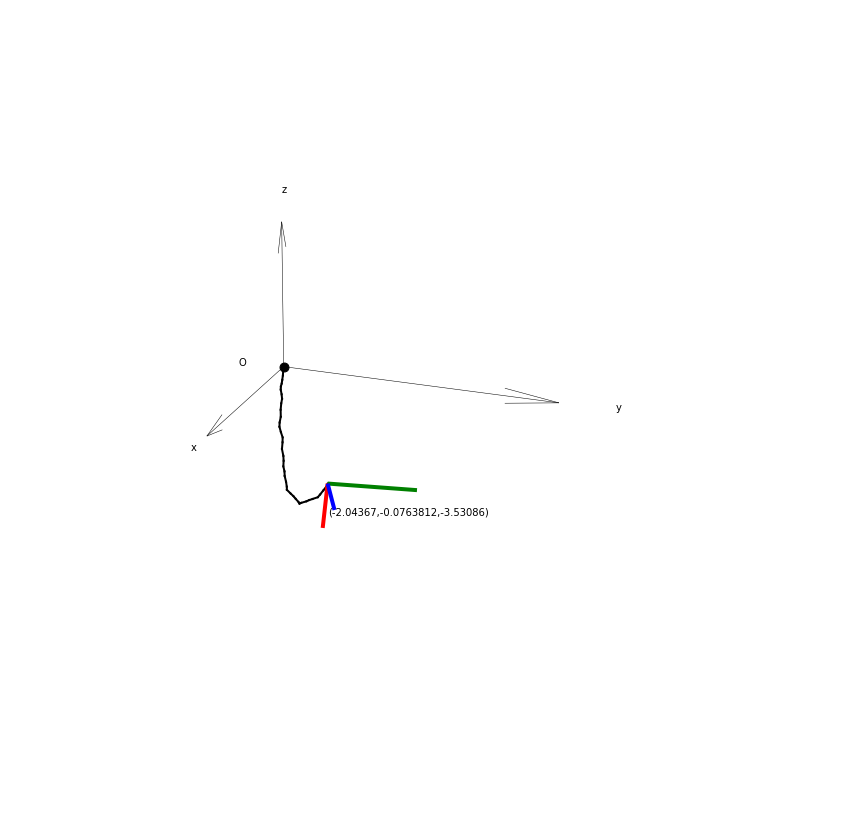

In [8]:
# Setup:
cfg = rs.config()
cfg.enable_device_from_file("../data/265.bag")
cfg.enable_stream(rs.stream.pose)
pipe = rs.pipeline()
pipe.start(cfg)

poses = []

for _ in range(50):
    time.sleep(0.01)
    clear_output(wait=True)
    
    frames = pipe.wait_for_frames()
    pose = frames.get_pose_frame()
    if pose:
        data = pose.get_pose_data()
        data_rot = [float(i.strip('xyzw: ')) for i in str(data.rotation).split(', ')]
        r = R.from_quat(data_rot)
        rotation = np.array(r.as_matrix())
        translation = np.array([float(i.strip('xyzw: ')) for i in str(data.translation).split(', ')])[np.newaxis].T
        T = np.hstack((rotation, translation))
        T = np.vstack((T, np.array([0, 0, 0, 1])))
        poses.append(T)
        plot_pose(poses=poses)
        
pipe.stop()